In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import numpy as np
import cv2

import rcnn.simple_nn as nn
from rcnn.MOT_parser import get_data
from rcnn.data_generators import get_anchor, video_streamer

import pickle

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
from random import seed
seed(1234)
np.random.seed(1234)

In [4]:
data,_,_ = get_data(['/data_cache/MOT16/'], form='jpg', part='test')
#data,_,_ = get_data(['/tmp/MOT16/'], form='jpg', part='train')

Parsing annotation files
Unable to fetch frames in /data_cache/MOT16/test/MOT16-12, passing


In [5]:
with open('config.pickle', 'rb') as f:
    C = pickle.load(f)

#C.rpn_stride = 8
#C.im_size = 200

In [6]:
#C.anchor_box_ratios = [[150, 300]]

#C.anchor_box_scales = np.arange(0.05, 1.1, 0.1)
print(C.anchor_box_ratios, C.anchor_box_scales)

[[150, 300]] [ 0.15  0.35  0.55  0.75  0.95]


In [7]:
nframes = 40

In [8]:
data_gen = video_streamer(data, 2, C, lambda x,y: [x//C.rpn_stride,y//C.rpn_stride], 
                          'tf', 'test', frame_batchsize=nframes)

In [9]:
x = next(data_gen)

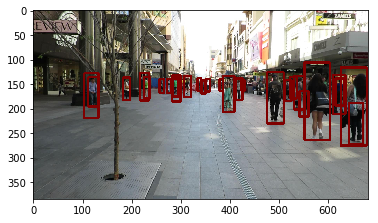

In [10]:
for t in [8]:
    im = x[0][0,t].copy()
    im -= im.min()
    im /= im.max()

    bbs = x[-1][0][t]['bboxes']
    for bb in bbs:
        a,b,c,d = map(lambda x: int(x/(1080/C.im_size)), [bb['x1'], bb['y1'], bb['x2'], bb['y2']])
        im -= im.min()
        im /= im.max()
        cv2.rectangle(im, (a,b), (c,d), color=0.5, thickness=3)
        #im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
    plt.imshow(im)
    plt.show()

In [11]:
bbs[:5]

[{'class': 'bbox', 'x1': 1340, 'x2': 1437, 'y1': 355, 'y2': 649},
 {'class': 'bbox', 'x1': 1732, 'x2': 1783, 'y1': 391, 'y2': 548},
 {'class': 'bbox', 'x1': 317, 'x2': 372, 'y1': 385, 'y2': 553},
 {'class': 'bbox', 'x1': 1161, 'x2': 1200, 'y1': 393, 'y2': 512},
 {'class': 'bbox', 'x1': 1495, 'x2': 1558, 'y1': 377, 'y2': 570}]

In [12]:
num_anchors = len(C.anchor_box_ratios) * len(C.anchor_box_scales)

In [13]:
x[1][0][0,0].shape

(48, 85, 10)

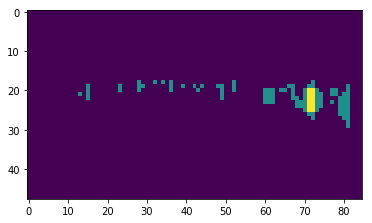

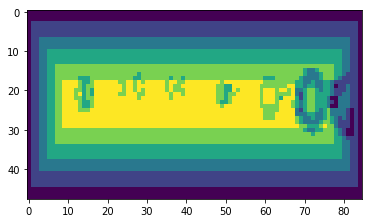

In [14]:
plt.imshow((x[1][0][0,t][...,-num_anchors:]).sum(axis=-1))
plt.show()
plt.imshow((x[1][0][0,t][...,:-num_anchors]).sum(axis=-1))
plt.show()

In [15]:
sess = tf.Session()

In [16]:
video_input = tf.placeholder(tf.float32, [None,None,None,None,3], name='video_input')
roi_input = tf.placeholder(tf.int64, [None,None,4], name='roi_input')
feature_map_input = tf.placeholder(tf.float32, [1, None, None, nn.shared_dim], 'feature_map_input')

In [17]:
C.num_rois = 32

In [18]:
base, base_model = nn.build_shared(video_input, stop_gradient=True)
rpn = nn.build_rpn(base, num_anchors)

classifier = nn.classifier(roi_input, C.num_rois, nb_classes=len(C.class_mapping), trainable=False)(feature_map_input)

In [19]:
base_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [20]:
saver = tf.train.Saver()

In [21]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}

print(class_mapping)

class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'bbox', 1: 'bg'}


In [22]:
rpn[0] = tf.nn.sigmoid(rpn[0])
classifier[0] = tf.nn.softmax(classifier[0])

#ROIs = []

def predict_rpn_and_featuremap(X):
    return sess.run(rpn + [base], {video_input:X})

def predict_classifier(features, ROI):
    #global ROIs
    #ROIs.append(ROI)
    return sess.run(classifier, {feature_map_input: features, roi_input:ROI})

In [23]:
saver.restore(sess, './experiment_save/with_det')

INFO:tensorflow:Restoring parameters from ./experiment_save/with_det


In [24]:
from rcnn.prediction_to_bb import extract_for_det, extract_for_rpn

In [25]:
extract_for_rpn(x[0][0], C)
print('1')

1


In [26]:
preds_n_base = predict_rpn_and_featuremap(x[0])

In [27]:
Y1, Y2, base_ = preds_n_base

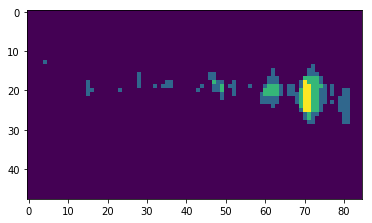

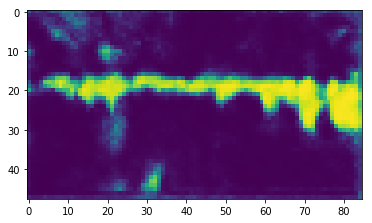

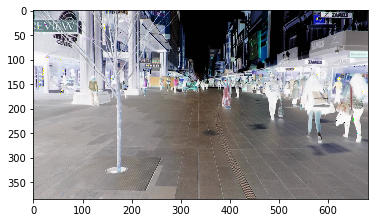

In [28]:
t = 4
plt.imshow((x[1][0][0,t][...,num_anchors:]).sum(axis=-1))
plt.show()
plt.imshow(Y1[0,t].max(axis=-1), vmin=0, vmax=1)
plt.show()
plt.imshow(x[0][0,t] - x[0][0,t].min())
plt.show()

In [65]:
thresh = 0.82
bbs = extract_for_det(Y1[:,t], Y2[:,t], base_[:,t], predict_classifier, C, bbox_threshold=thresh)

In [66]:
bbs

[[488, 120, 528, 216],
 [592, 104, 640, 240],
 [560, 128, 584, 192],
 [304, 128, 312, 152],
 [392, 120, 424, 192],
 [64, 104, 104, 200],
 [344, 128, 352, 160],
 [328, 128, 336, 160]]

In [67]:
preds = Y1

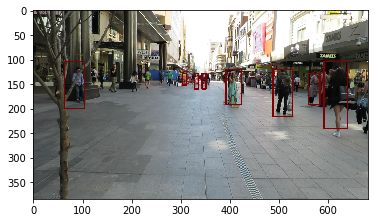

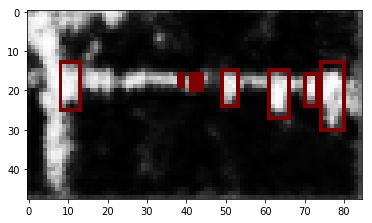

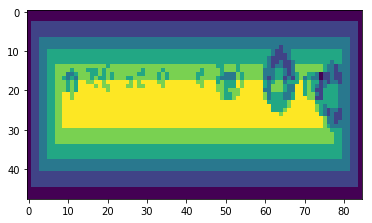

In [68]:
for im, real in [(x[0][0,t] - x[0][0,t].min(), True), (np.stack([preds[0,t].max(axis=-1)]*3,  axis=-1), False)]:
    for bb in bbs:
        a,b,c,d = map(lambda x: x//C.rpn_stride, bb)
        
        if real:
            a,b,c,d = map(lambda x: x*C.rpn_stride, [a,b,c,d])
            
        im -= im.min()
        im /= im.max()
        
        thick = 1
        if real:
            thick = 2
            
        cv2.rectangle(im, (a,b), (c,d), color=0.5, thickness=thick)
        #im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()
plt.imshow((x[1][0][0,t][...,:num_anchors]).sum(axis=-1))
plt.show()

In [69]:
preds = Y1
results = []
for t in range(nframes):
    bbs = extract_for_det(Y1[:,t], Y2[:,t], base_[:,t], predict_classifier, C, bbox_threshold=thresh)
    im = x[0][0,t] - x[0][0,t].min()
    for bb in bbs:
        a,b,c,d = map(lambda x: x, bb)

        im -= im.min()
        im /= im.max()
        thick = 2
        cv2.rectangle(im, (a,b), (c,d), color=0.5, thickness=thick)
        #im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
    results.append(im)

In [70]:
!rm -R /tmp/results
!mkdir /tmp/results

In [71]:
from scipy.misc import imsave

In [72]:
for i, pic in enumerate(results):
    imsave('/tmp/results/{}.jpg'.format(i), pic)